# Interactive Dynesty Demo

This is an interactive version of the demo demonstrating dynesty usage. It runs over the same mock data using a similar procedure as the implementation in the default *prospector.py* Python script. 

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
import numpy as np
from matplotlib.pyplot import *

%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [3]:
import fsps
import sedpy
import prospect

/home/joshspeagle/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Setup

We now want to initialize our model.

In [4]:
from prospect.models import model_setup

The overall or meta-parameters controlling how the fit is done are stored in the ``run_params`` dictionary, which is a mix of options
  1. defined in the parameter file
  2. specified at the command line (if not running in interactive mode.)

Let's load them from the parameter file and look at them:

In [5]:
clargs = {'param_file':'demo_mock_params.py'}
run_params = model_setup.get_run_params(argv='demo_mock_params.py', **clargs)
print(run_params)

{'tau': 3.0, 'verbose': True, 'niter': 512, 'normalize_spectrum': False, 'initial_disp': 0.1, 'do_levenburg': True, 'outfile': 'output/demo_mock', 'nburn': [32, 32, 64], 'nestle_npoints': 200, 'maxfev': 5000, 'do_powell': False, 'nwalkers': 128, 'mass': 10000000000.0, 'param_file': 'demo_mock_params.py', 'ftol': 5e-06, 'logzsol': -0.5, 'dust2': 0.3, 'tage': 12.0, 'zred': 0.1, 'zcontinuous': 1, 'nmin': 10, 'debug': False, 'snr': 20.0, 'add_noise': False, 'nestle_method': 'single', 'logify_spectrum': False, 'nestle_maxcall': 1000000}


Our model will be composed of four components:
- an **stellar population synthesis (SPS)** model for the underlying physical parameters,
- an underlying **statistical model** composed of a set of parameters, priors, etc., 
- a **noise model** for the underlying calibration vector, and
- a set of **observations** we are trying to fit.

See the *demo_mock_params.py* file for additional info on the specific parameters we are initializing here.

The SPS model specified in the ``load_obs`` method of the parameter file can be one of several different types, corresponding to different SFH parameterizations.  Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations as described in the FSPS manual with `sfh_type` of 1, 4, or 5.

In [6]:
# load sps model (default)
sps = model_setup.load_sps(**run_params)
print(sps)

For now we set the noise models to ``None``, which means that the default simple $\chi^2$ style likelihood will be used.

In [7]:
# load noise model (none)
spec_noise, phot_noise = model_setup.load_gp(**run_params)

The model object keeps track of the fit parameters and their priors.

In [8]:
# demo model
model = model_setup.load_model(**run_params)

The `obs` dictionary contains all our observational data, from which we are attempting to infer posterior PDFs for the parameters.  Guidelines for units and what keys must be in the `obs` dictionary can be found in the documentation.

In [9]:
# demo data (generated from the script)
obs = model_setup.load_obs(**run_params)
print('Mock S/N={}'.format(obs['mock_snr']))
if run_params['add_noise']:
    print('Noise realization added to mock photometry')
else:
    print('No noise added to mock photometry')

reading py script demo_mock_params.py
Mock S/N=20.0
No noise added to mock photometry


Now that we've initialized the components of our model, we need to define how we want to compare our model to the data by establishing the appropriate **likelihood**. In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from Prospector.

In [10]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

In [11]:
def lnprobfn(theta):
    """Given a parameter vector, a dictionary of observational data 
    and a model object, return the ln of the posterior. 
    This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    # Calculate prior probability and exit if not within prior
    lnp_prior = model.prior_product(theta, nested=True)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate mean model
    t1 = time.time()
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return -np.infty
    d1 = time.time() - t1
    vectors = {}  # This would be used for noise model weight functions

    # Calculate likelihoods
    t2 = time.time()
    lnp_spec = lnlike_spec(spec, obs=obs, spec_noise=spec_noise)
    lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise)
    d2 = time.time() - t2
    #if verbose:
    #    write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

    return lnp_prior + lnp_phot + lnp_spec

## Running Prospector

### Outputs

Before we start running anything, let's just check whether we can write out our fits to an HDF5 file. If not, we'll just dump them at the end.

In [12]:
from prospect.io import write_results

In [13]:
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = outroot + '_mcmc.h5'
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

Writing to file output/demo_mock_1502312075_mcmc.h5
Could not JSON serialize mock_params, pickled instead


### Model Preview

Let's also take a quick look at our model/data to get a sense of what we're dealing with and what we're fitting for.

In [14]:
print 'Free params:', model.free_params
print 'Fixed params:', model.fixed_params

Free params: ['mass', 'logzsol', 'tau', 'tage', 'dust2']
Fixed params: ['zred', 'sfh', 'pmetals', 'fage_burst', 'tburst', 'fburst', 'dust1', 'dust_tesc', 'dust_index', 'dust1_index', 'dust_type', 'add_dust_emission', 'duste_umin', 'tpagb_norm_type', 'add_agb_dust_model', 'agb_dust', 'add_neb_emission', 'gas_logz', 'gas_logu', 'phot_jitter']


So we're fitting for 5 parameters here:
- stellar mass $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), 
- age $t$ of the galaxy, and 
- dust attenuation of old stellar populations $A_V$.

Everything else here is fixed explicitly in the *demo_mock_params.py* file.  There are many other parameters that are set implicitly in the FSPS defaults.

### SED Preview

Let's now see what our model and data look like.

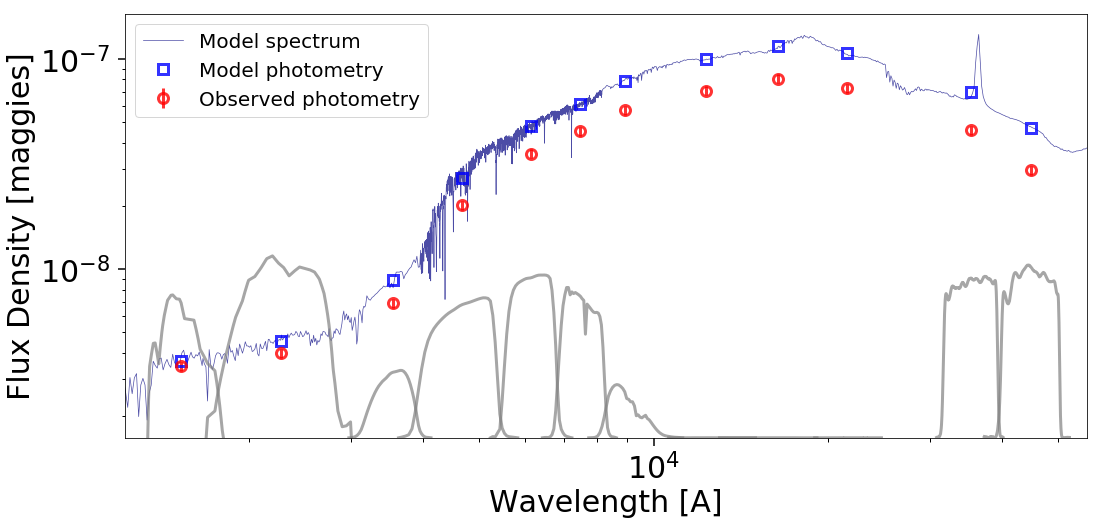

In [15]:
wspec = sps.csp.wavelengths  # *restframe* spectral wavelengths
a = 1.0 + model.params.get('zred', 0.0)  # cosmological redshifting

# photometric effective wavelengths
wphot = np.array([f.wave_effective for f in obs['filters']])

# initial parameters

initial_theta = model.rectify_theta(model.initial_theta)

# generate model
out_init = model.mean_model(initial_theta, obs, sps=sps) 
mspec_init, mphot_init, mextra_init = out_init

# establish bounds
xmin, xmax = np.min(wphot) * 0.8, np.max(wphot) / 0.8
temp = np.interp(np.linspace(xmin, xmax, 10000), wspec * a, mspec_init)
ymin, ymax = temp.min() * 0.8, temp.max() / 0.8

# set up figure
figure(figsize=(16, 8))

# plot model + data
loglog(wspec * a, mspec_init, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, mphot_init, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1 * (ymax-ymin) * t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Minimization Step

With nested sampling we don't need to minimize since we begin sampling directly from the prior.

### Sampling the Posterior

Now that we've got all the objects set up, we can begin sampling from the posterior using **Nested Sampling**. Prospector by default uses **emcee**, but here we will try to use [**nestle**](https://github.com/kbarbary/nestle) and then [**dynesty**](https://github.com/joshspeagle/dynesty). For nested sampling we need to define a prior transfrom function. This is easy with new-style prior objects in Prospector, where a prior_transform method is defined by the model object. We also need to make sure that the prior probability calculation in the posterior probability function is appropriate for nested sampling (note the `nested=True` option in `model.prior_product` in the `lnprobfn` above).

In [16]:
def prior_transform(u):        
    return model.prior_transform(u)

Note that creating a new model with FSPS is somewhat time-intensive, but once the relevant model(s) have been loaded they are subsequently stored in cache so similar models can be generated much more quickly.

### Nestle

First up is **nestle**.

In [17]:
import nestle

In [24]:
tstart = time.time()  # time it
result = nestle.sample(lnprobfn, prior_transform, model.ndim,
                       method='multi', npoints=200,
                       callback=None, dlogz=0.01)
dur = time.time() - tstart

print('done nestle in {0}s'.format(dur))

done nestle in 120.058165073s


dynesty has a bunch of plotting utilities that are useful for visualizing results. We'll import these first just to visualize our nestle results.

In [19]:
from dynesty import plotting as dyplot

In [25]:
result['samples'][:, 0] = np.log10(result['samples'][:, 0])  # logify mass

efficiency = 31.3545725418%


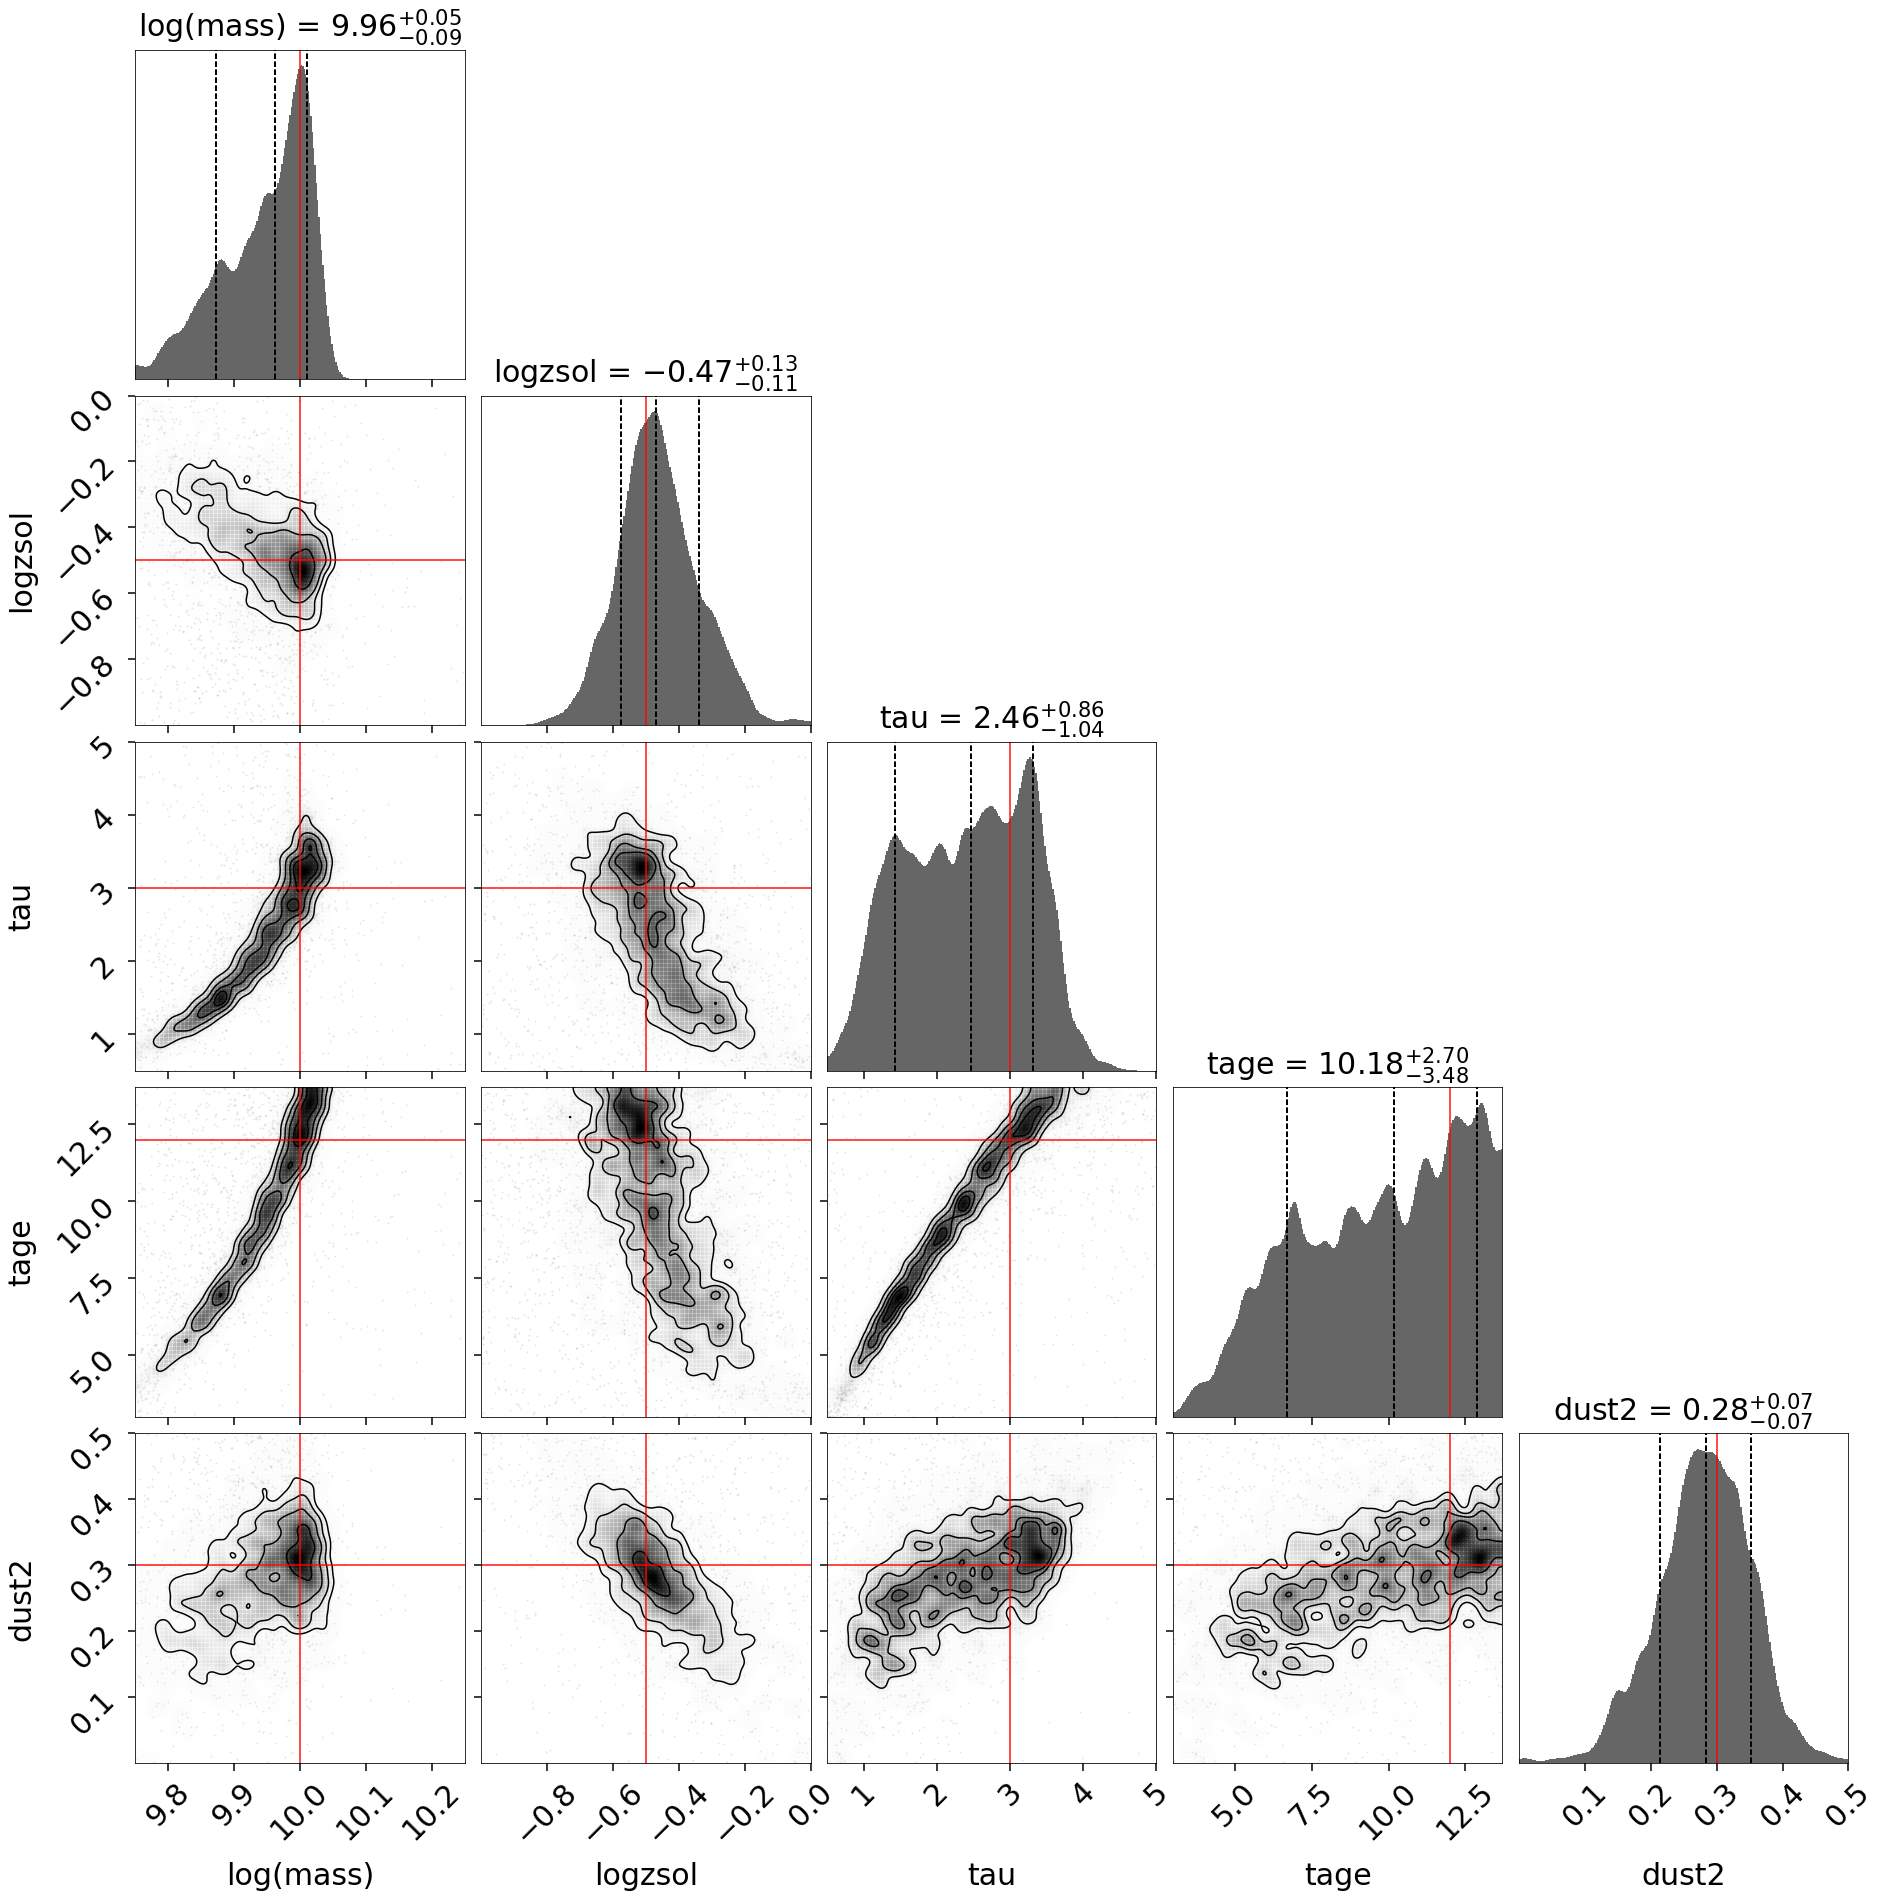

In [47]:
print('efficiency = {}%'.format(len(result['samples']) * 100.0 / result['ncall']))

# truth values
theta_truth = np.array([run_params[i] 
                        for i in ['mass','logzsol','tau','tage','dust2']])
theta_truth[0] = np.log10(theta_truth[0])

# labels
labels = np.copy(model.free_params).astype('S16')
labels[0] = 'log(mass)'

# bounds
ranges = [(9.75, 10.25), (-1, 0.), (0.5, 5), (3, 13.7), (0.,0.5)]

# corner plot
rfig, rax = dyplot.cornerplot(result, bounds=ranges, labels=labels, truths=theta_truth,
                              show_titles=True, title_kwargs={'fontsize': 30, 'y': 1.02},
                              fig=subplots(5, 5, figsize=(27, 27)))

This looks similar to the **emcee** result in the original demo, albeit noisier.

### dynesty

Now lets try **dynesty**.

In [27]:
import dynesty

In [28]:
tstart = time.time()  # time it
nsampler = dynesty.NestedSampler(lnprobfn, prior_transform, model.ndim,
                                 bound='multi', sample='unif', nlive=200,
                                 **{'bootstrap': 0})
nsampler.run_nested(dlogz=0.01)
nresult = nsampler.results
ndur = time.time() - tstart

print('done dynesty in {0}s'.format(ndur))

iter: 3910+200 | nc: 1 | ncall: 13340 | eff(%): 30.810 | logz: 219.557 +/-  0.253 | dlogz:  0.000 <  0.010    


done dynesty in 131.4728899s


/home/joshspeagle/anaconda/lib/python2.7/site-packages/dynesty-0.6.5-py2.7.egg/dynesty/sampler.py:183: RuntimeWarning: invalid value encountered in sqrt


In [29]:
nresult['samples'][:, 0] = np.log10(nresult['samples'][:, 0])  # logify mass

efficiency = 30.8095952024%


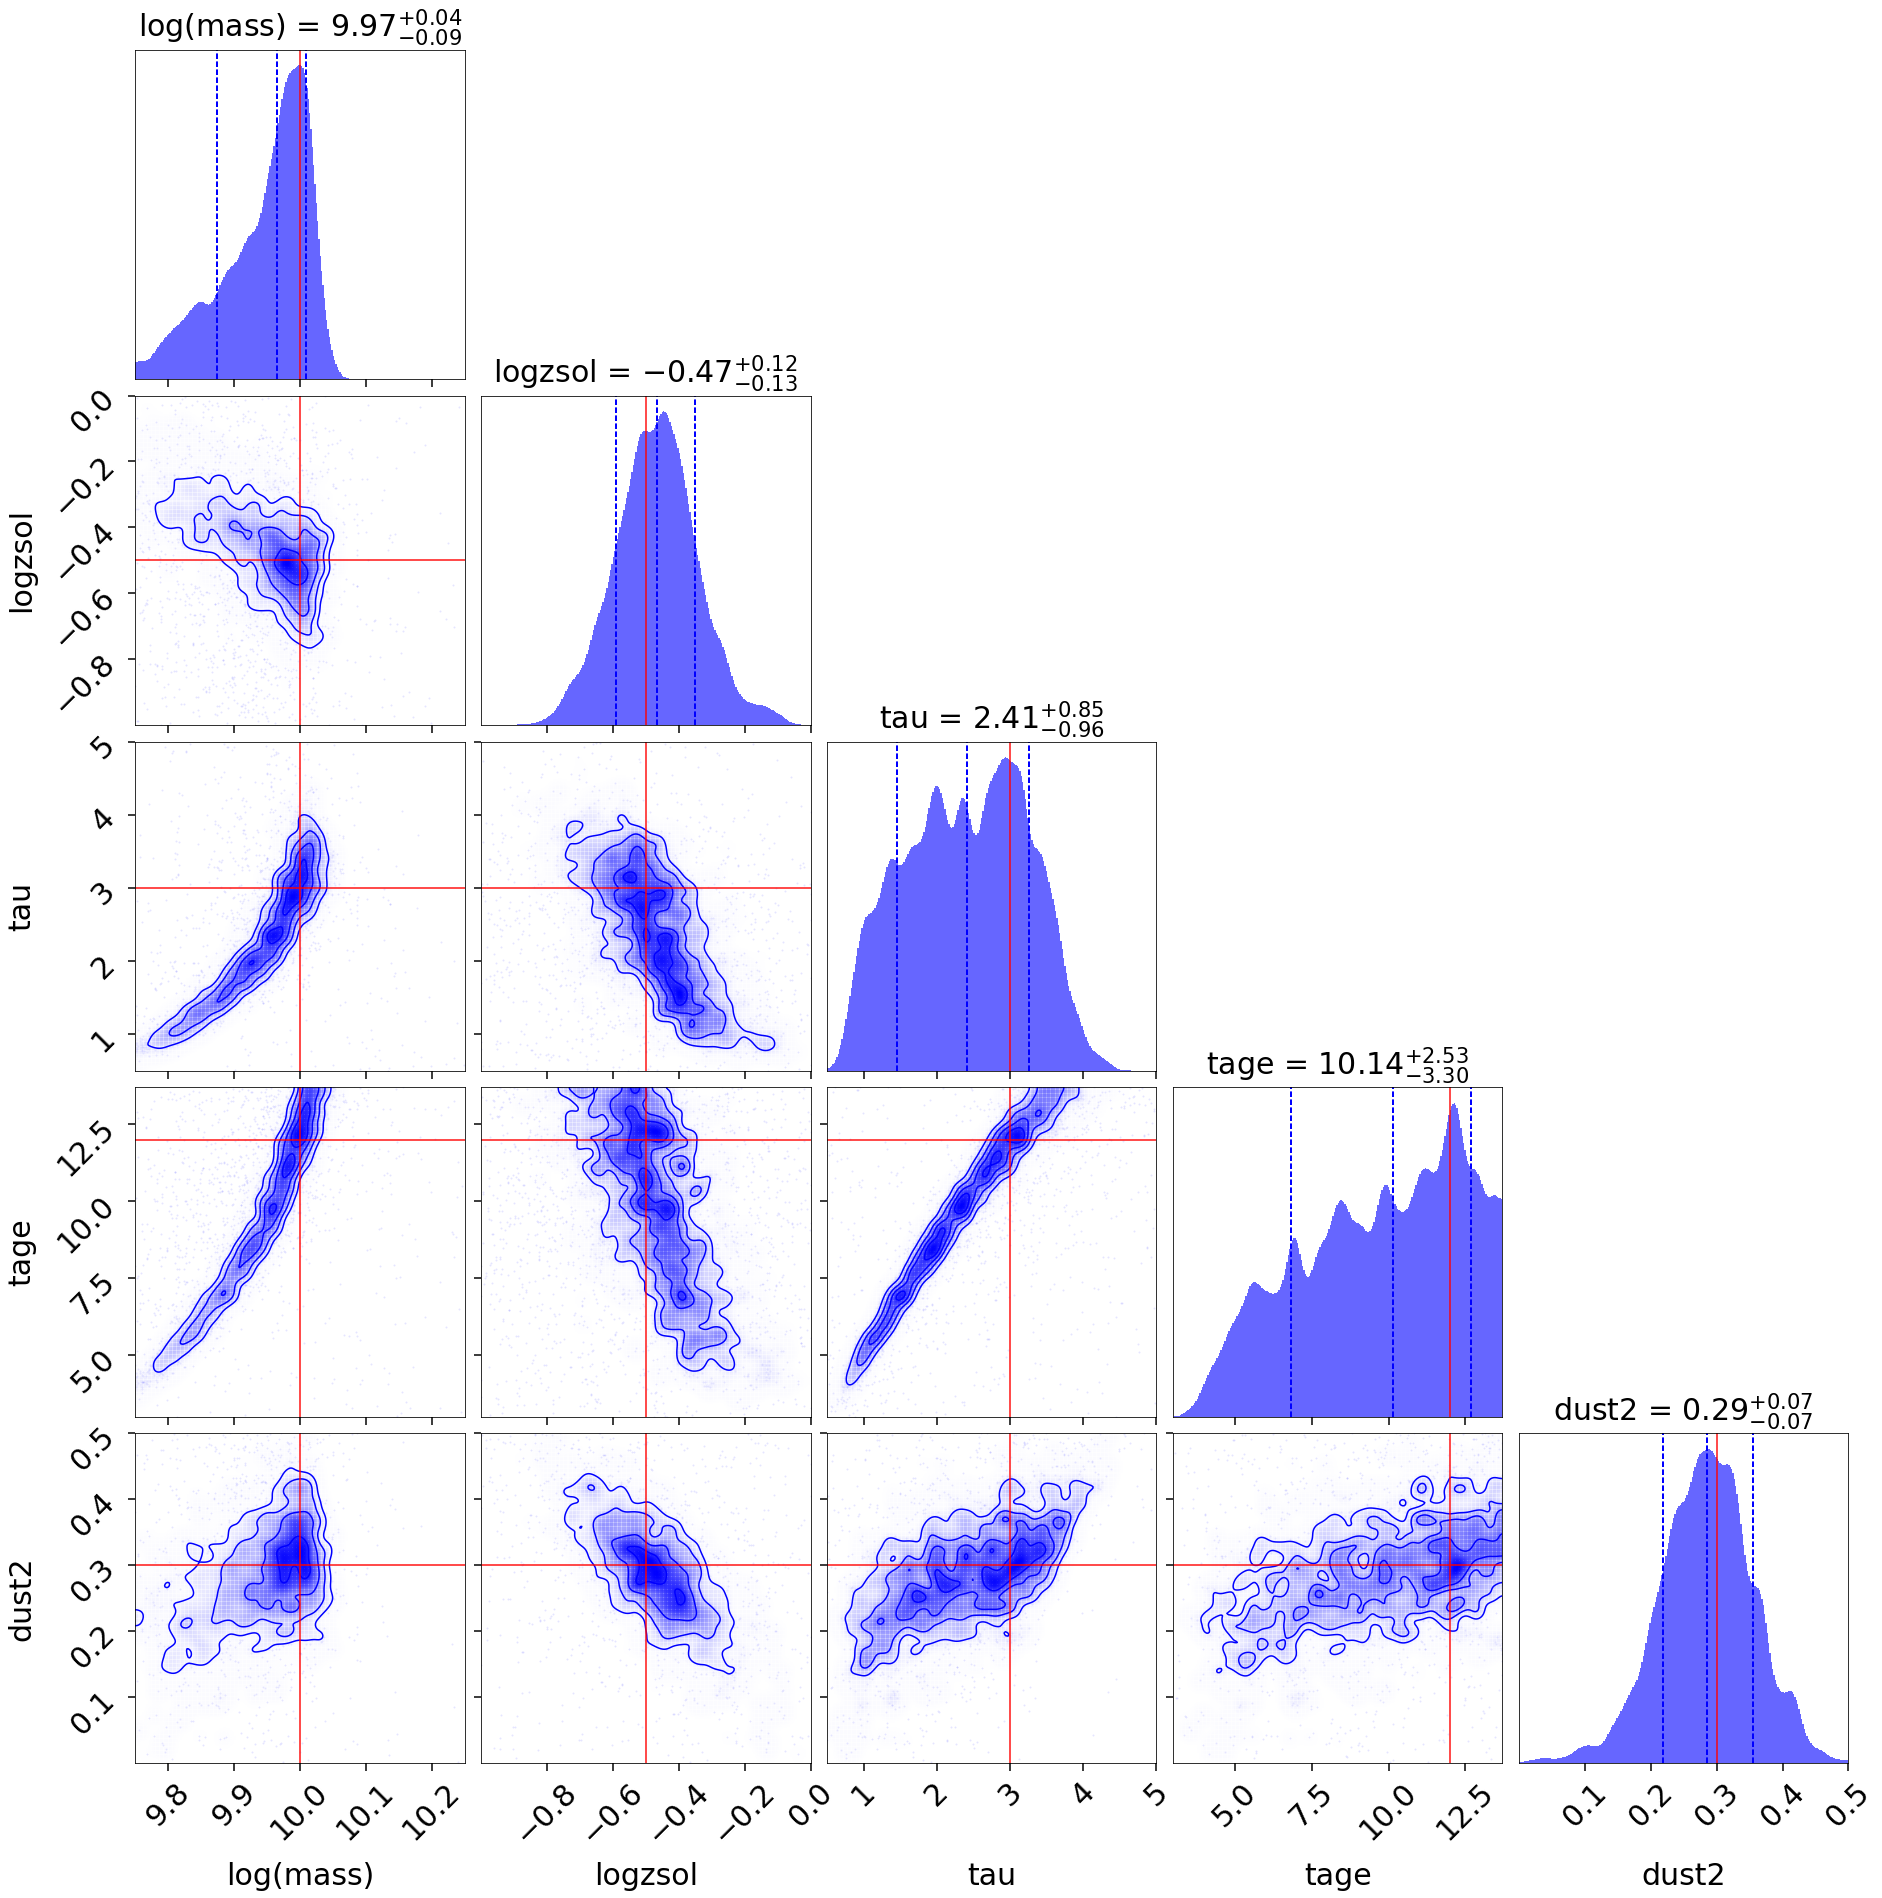

In [48]:
print('efficiency = {0}%'.format(nresult.eff))

# corner plot
rfig, rax = dyplot.cornerplot(nresult, bounds=ranges, labels=labels, truths=theta_truth,
                              color='blue', 
                              show_titles=True, title_kwargs={'fontsize': 30, 'y': 1.02},
                              fig=subplots(5, 5, figsize=(27, 27)))

The results look quite similar to those from nestle. Dynesty also has a couple other visualization tools that can help visualize nested sampling results.

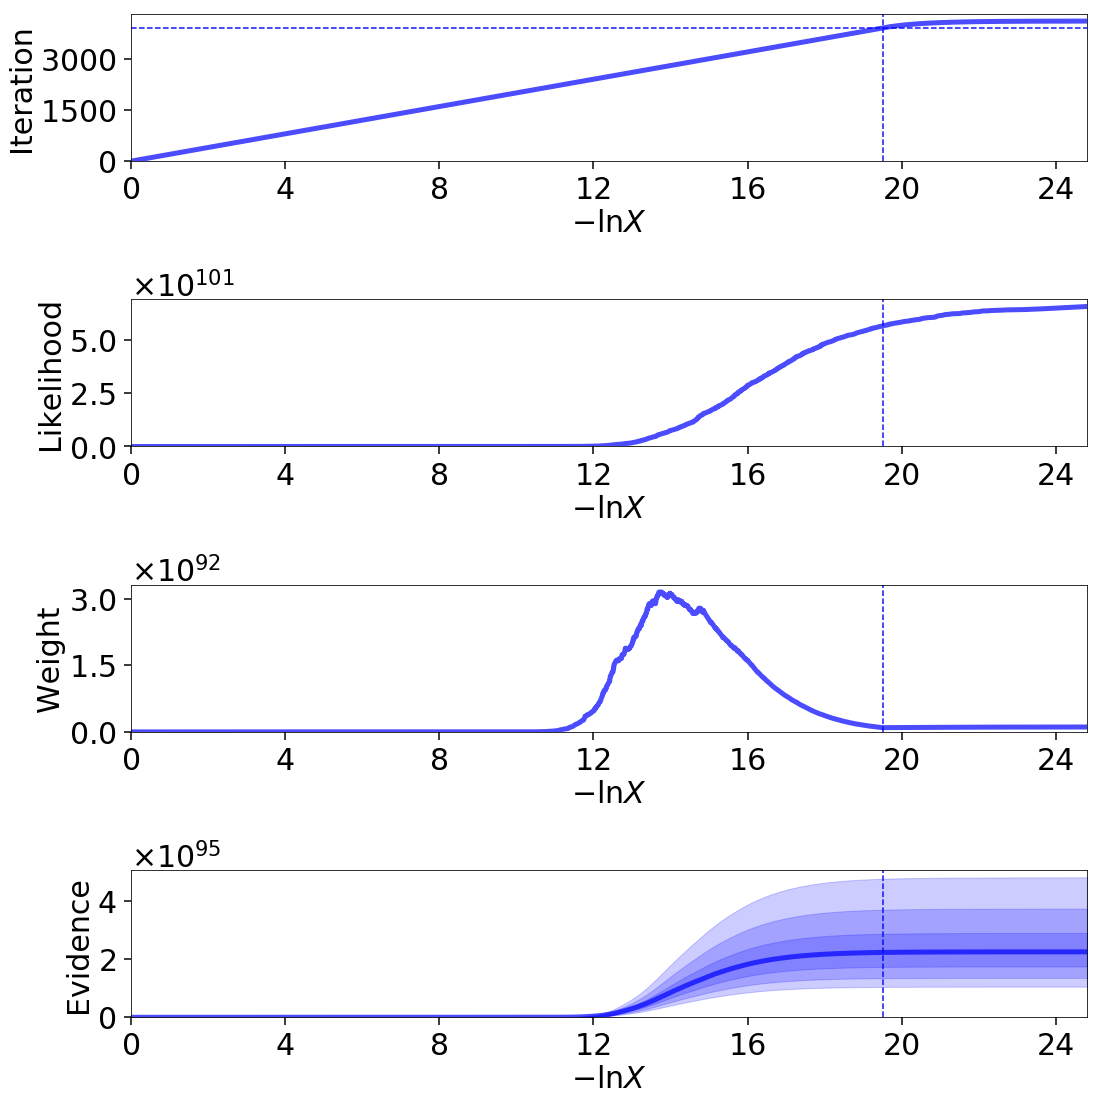

In [49]:
rfig, rax = dyplot.runplot(nresult)
tight_layout()

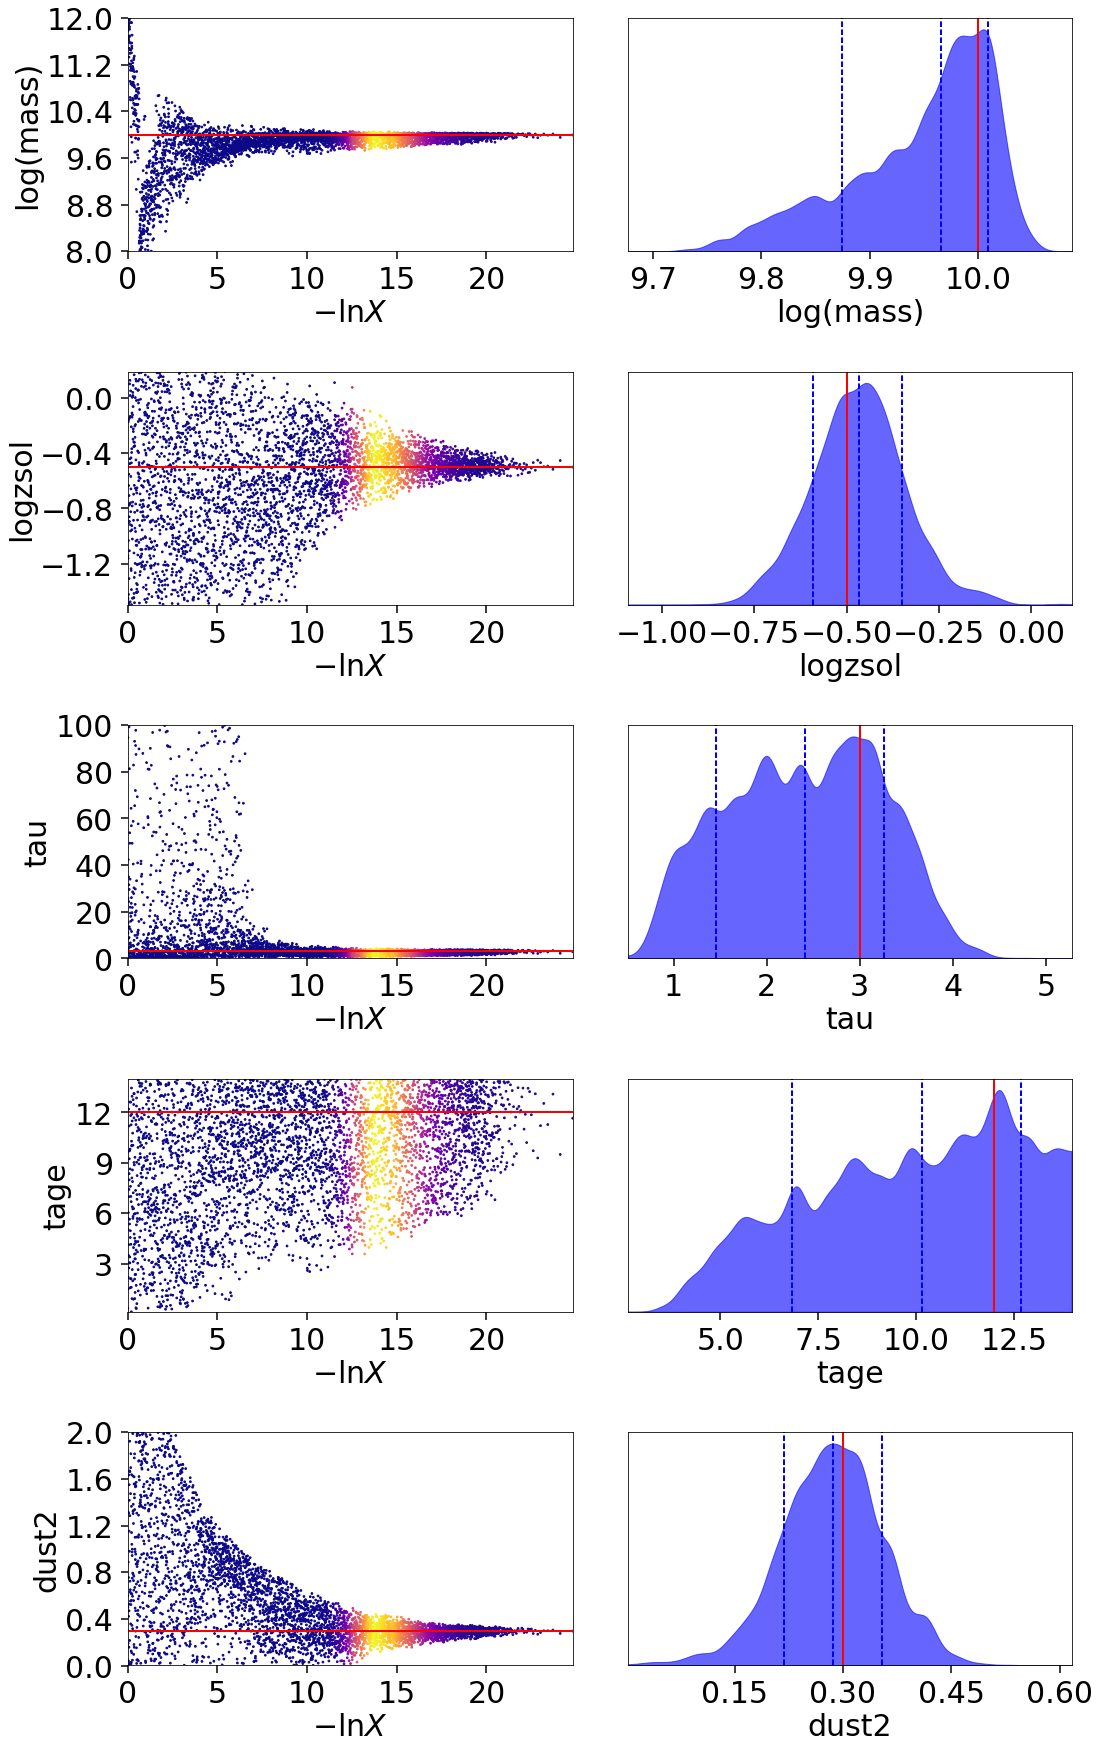

In [50]:
rfig, rax = dyplot.traceplot(nresult, labels=labels, truths=theta_truth,
                               fig=subplots(5, 2, figsize=(16, 25)))
tight_layout()

In addition to standard nested sampling, dynesty also implements **dynamic nested sampling**, which allows live points to be allocated dynamically. By default, the dynamic nested sampler in dynesty prioritizes posterior inference over evidence (80% posterior vs 20% evidence weighting). It also includes automated stopping criteria to measure posterior and evidence convergence, although by default only the posterior contributions are considered (i.e. 100% posterior vs 0% evidence weighting).

In [51]:
tstart = time.time()  # time it
dsampler = dynesty.DynamicNestedSampler(lnprobfn, prior_transform, model.ndim,
                                        bound='multi', sample='unif',
                                        **{'bootstrap': 0})
dsampler.run_nested(dlogz_init=0.01, nlive_init=200, nlive_batch=1000, wt_kwargs={'pfrac': 1.0})
dresult = dsampler.results
ddur = time.time() - tstart

print('done dynesty (dynamic) in {0}s'.format(ddur))

/home/joshspeagle/anaconda/lib/python2.7/site-packages/dynesty-0.6.5-py2.7.egg/dynesty/dynamicsampler.py:1328: RuntimeWarning: invalid value encountered in sqrt
iter: 4145 | batch: 0 | nc: 1 | ncall: 11629 | eff(%): 35.644 | logz: 219.371 +/-  0.256 | dlogz:  0.000 >  0.010    /home/joshspeagle/anaconda/lib/python2.7/site-packages/dynesty-0.6.5-py2.7.egg/dynesty/dynamicsampler.py:492: RuntimeWarning: invalid value encountered in sqrt
/home/joshspeagle/anaconda/lib/python2.7/site-packages/dynesty-0.6.5-py2.7.egg/dynesty/utils.py:465: RuntimeWarning: invalid value encountered in sqrt
/home/joshspeagle/anaconda/lib/python2.7/site-packages/dynesty-0.6.5-py2.7.egg/dynesty/utils.py:284: RuntimeWarning: invalid value encountered in sqrt
iter: 14893 | batch: 8 | nc: 3 | ncall: 48633 | eff(%): 30.623 | loglstar: 228.572 < 234.326 < 228.947 | logz: 219.408 +/-  0.247 | stop:  1.172     

done dynesty (dynamic) in 624.424292803s


In [52]:
dresult['samples'][:, 0] = np.log10(dresult['samples'][:, 0])  # logify mass10

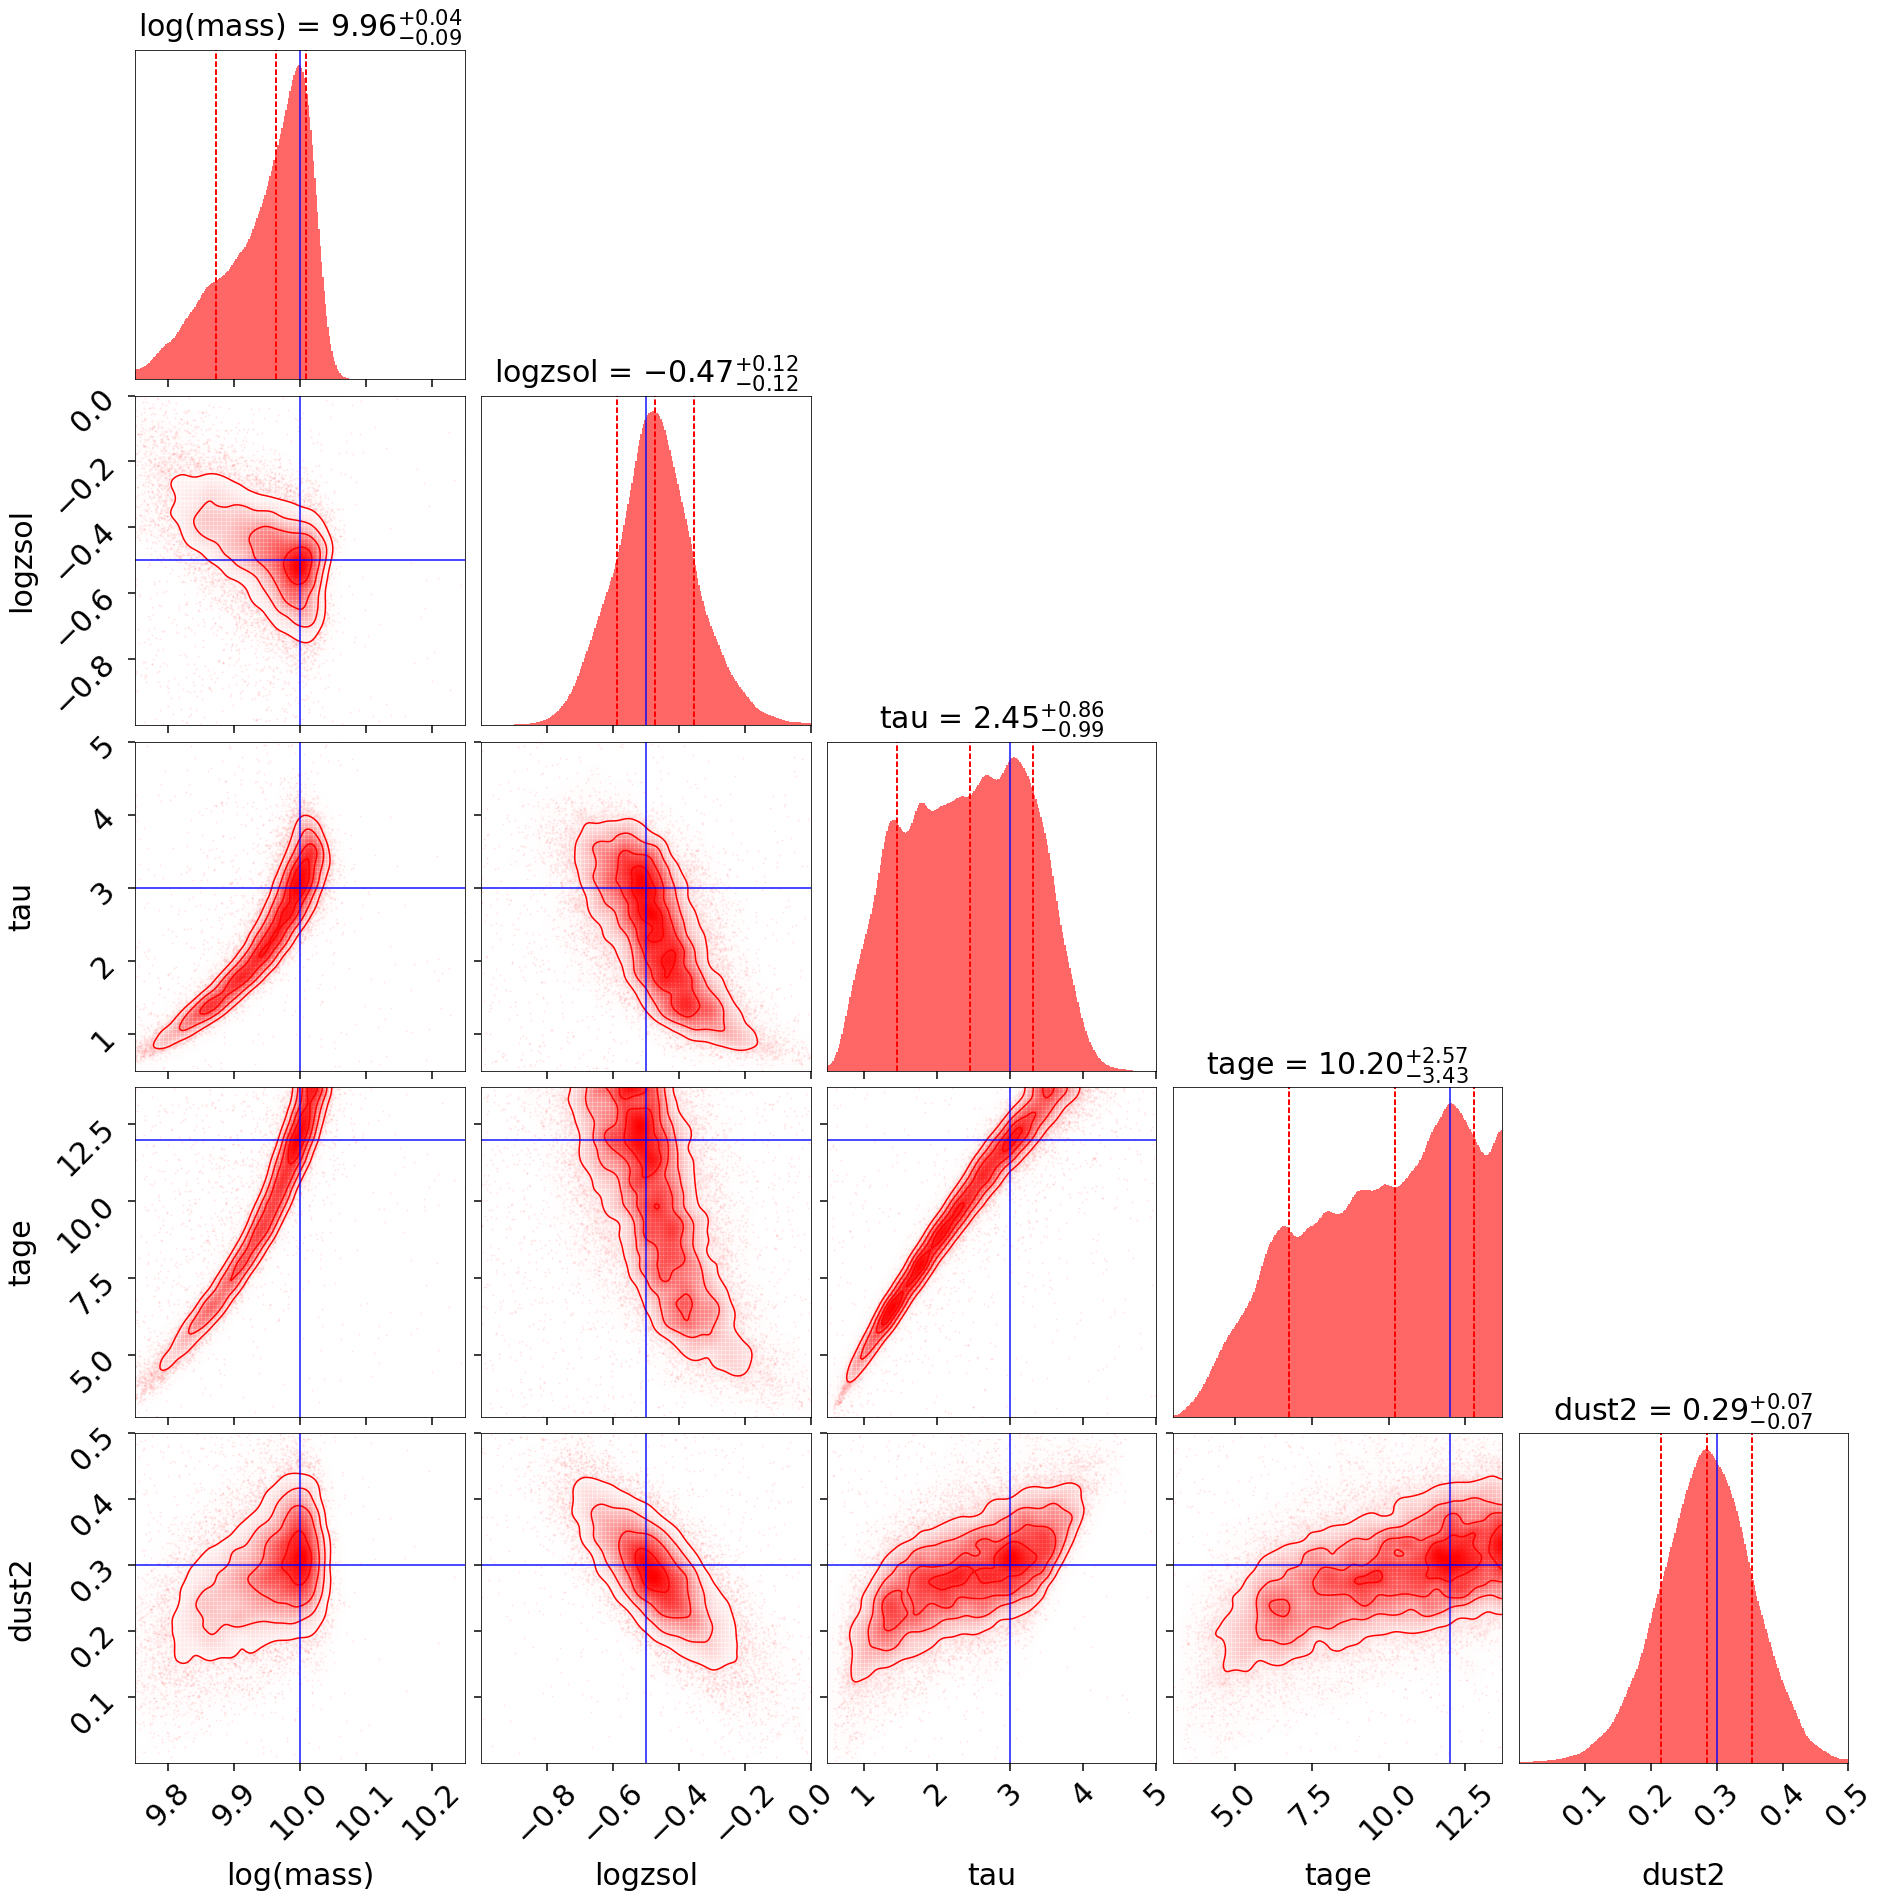

In [56]:
rfig, rax = dyplot.cornerplot(dresult, bounds=ranges, labels=labels, truths=theta_truth,
                              color='red', truth_color='blue',
                              show_titles=True, title_kwargs={'fontsize': 30, 'y': 1.02},
                              fig=subplots(5, 5, figsize=(27, 27)))

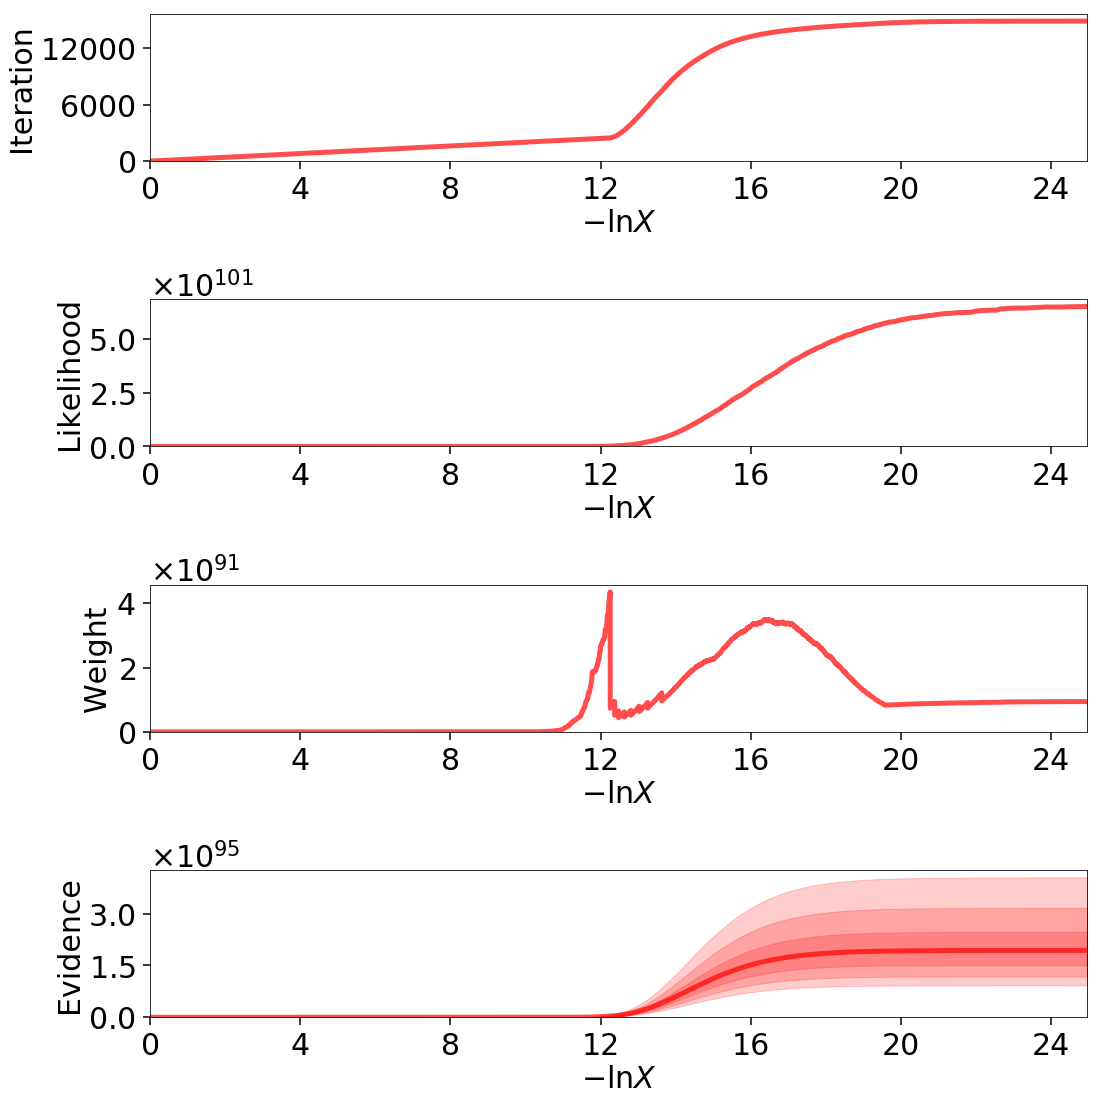

In [54]:
rfig, rax = dyplot.runplot(dresult, color='red')
tight_layout()

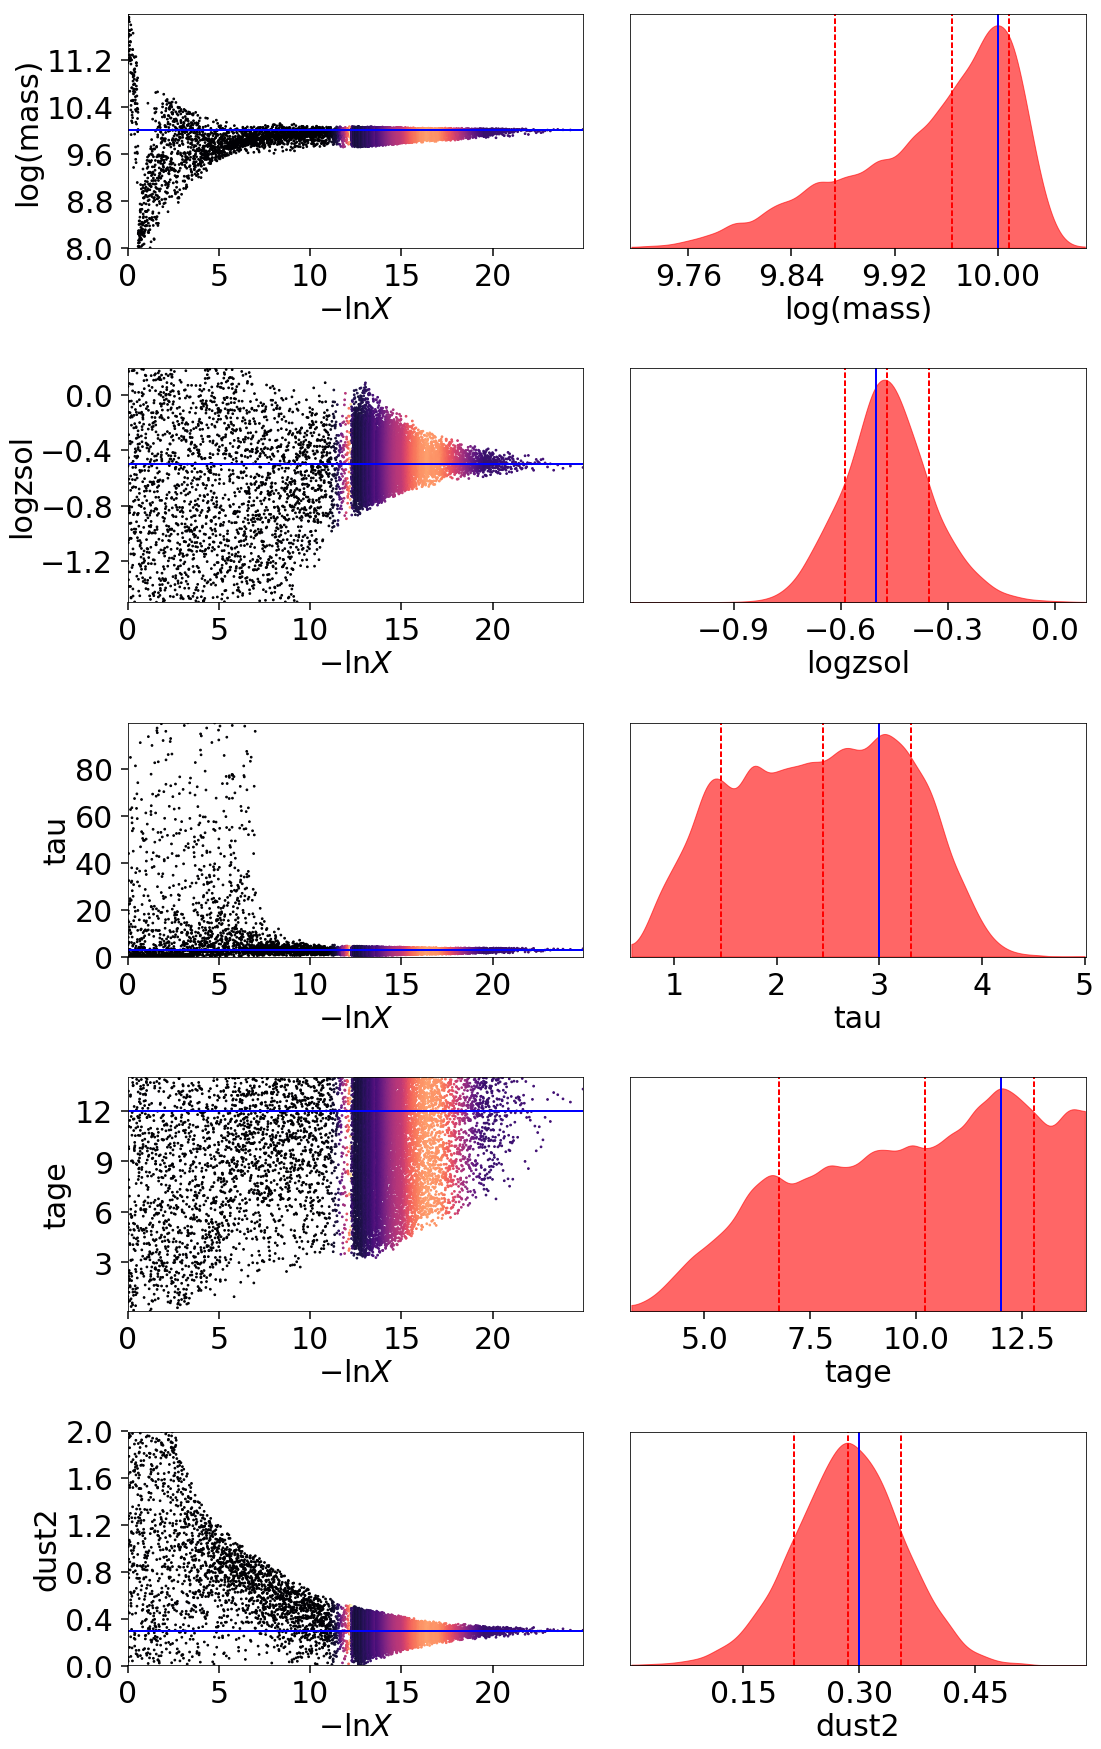

In [55]:
rfig, raxes = dyplot.traceplot(dresult, labels=labels, truths=theta_truth, trace_cmap='magma',
                               truth_color='blue', post_color='red',
                               fig=subplots(5, 2, figsize=(16, 25)))
tight_layout()

## Wrapping Up

Now that everything's all set, let's save our results to disk. These will be written to 2 or 3 files beginning with the value of `outroot`.

In [57]:
# Write the dynesty result object as a pickle  
import pickle
with open(outroot + '_ns.pkl', 'w') as f:
    pickle.dump(dresult, f)
partext = write_results.paramfile_string(**run_params)

# Write the model as a pickle
write_results.write_model_pickle(outroot + '_model', model, powell=None,
                                 paramfile_text=partext)

Finally, let's just take a look at a random model drawn from our chain.

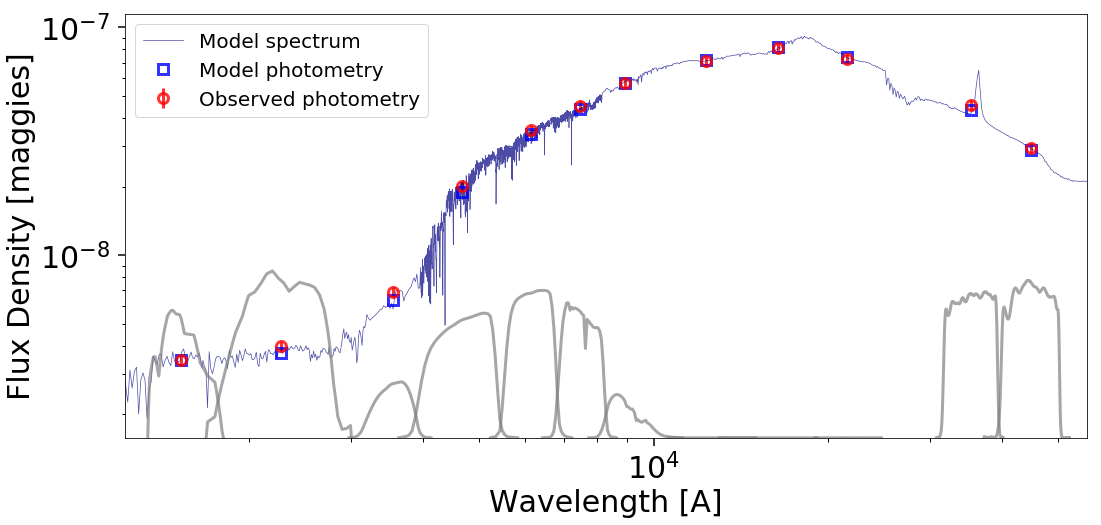

In [58]:
# randomly chosen parameters from chain
idx = np.random.choice(dresult['niter'], p=np.exp(dresult['logwt'] - dresult['logz'][-1]))
theta = dresult['samples'][idx]
theta[0] = 10**theta[0]  # un-logify mass

# generate model
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)

# establish bounds
xmin, xmax = wphot.min() * 0.8, wphot.max() / 0.8
temp = np.interp(np.linspace(xmin, xmax, 10000), wspec * a, mspec)
ymin, ymax = temp.min() * 0.8, temp.max() / 0.8

# set up figure
figure(figsize=(16, 8))

# plot data and model
loglog(wspec * a, mspec, label='Model spectrum',
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1 * (ymax-ymin) * t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()